In [ ]:
import torch.nn.functional as F
import torch
import torchvision
from matplotlib import pyplot as plt
import os
import torch
import random
from scipy import ndimage
from torchvision import utils
import matplotlib.pyplot as plt
import numpy as np
%matplotlib inline
from torchvision import transforms
import torch.nn as nn


root_dir = './'
torchvision.datasets.MNIST(root=root_dir,download=True)

# Load MNIST dataset
train_set = torchvision.datasets.MNIST(root=root_dir, download=True, train=True)
test_set = torchvision.datasets.MNIST(root=root_dir, download=True, train=False)

# Dataset len
num_train = len(train_set)
num_test = len(test_set)
print(f"Num. training samples: {num_train}")
print(f"Num. test samples:     {num_test}")

# extract data and targets
x_train, y_train=train_set.data,train_set.targets
print(x_train.shape)
print(y_train.shape)

Non_num_types = 11
nr_ex = 5400*Non_num_types

vettore = torch.arange(nr_ex) % Non_num_types
vettore_mischiato = vettore[torch.randperm(len(vettore))]
print(vettore_mischiato)

nums, count = torch.unique(vettore_mischiato, return_counts=True)
print(nums)
print(count)

idxs_digits_trainSet=[]
for digit in range(10):
  y = y_train==digit
  idxs_digits_trainSet.append(torch.where(y == 1)[0])

100%|██████████| 9912422/9912422 [00:00<00:00, 19752611.38it/s]


Extracting ./MNIST/raw/train-images-idx3-ubyte.gz to ./MNIST/raw



100%|██████████| 28881/28881 [00:00<00:00, 89465061.91it/s]


Extracting ./MNIST/raw/train-labels-idx1-ubyte.gz to ./MNIST/raw



100%|██████████| 1648877/1648877 [00:00<00:00, 25570469.26it/s]


Extracting ./MNIST/raw/t10k-images-idx3-ubyte.gz to ./MNIST/raw



100%|██████████| 4542/4542 [00:00<00:00, 9274843.61it/s]


Extracting ./MNIST/raw/t10k-labels-idx1-ubyte.gz to ./MNIST/raw

Num. training samples: 60000
Num. test samples:     10000
torch.Size([60000, 28, 28])
torch.Size([60000])
tensor([ 3,  8,  0,  ...,  1, 10,  8])
tensor([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10])
tensor([5400, 5400, 5400, 5400, 5400, 5400, 5400, 5400, 5400, 5400, 5400])


In [ ]:
mask = torch.unsqueeze(mask,1)
mask_int = F.interpolate(mask, size=(32, 32), mode='bilinear') 

In [ ]:
from google.colab import drive
drive.mount('/content/drive')
n=59399

folder = '/content/drive/MyDrive/Train_VGG_NonNum/train_set_VGG_'+str(n)+'.pt'
folder_lbl = '/content/drive/MyDrive/Train_VGG_NonNum/type_train_set_VGG_'+str(n)+'.pt'
mask = torch.load(folder)
lbls = torch.load(folder_lbl)

Mounted at /content/drive


In [ ]:
from google.colab import drive
drive.mount('/content/drive')
n=75600

folder = '/content/drive/MyDrive/Train_VGG_NonNum/train_set_VGG_'+str(n)+'.pt'
folder_lbl = '/content/drive/MyDrive/Train_VGG_NonNum/type_train_set_VGG_'+str(n)+'.pt'
mask = torch.load(folder)
lbls = torch.load(folder_lbl)

mask_int = F.interpolate(mask, size=(32, 32), mode='bilinear') 

n_per_cat = 2700
nums, count = torch.unique(lbls, return_counts=True)


# Inizializza un tensore vuoto per contenere i campioni bilanciati
balanced_lbls = torch.zeros_like(lbls, dtype=torch.long)

# per ogni categoria, seleziona casualmente 50 indici di elementi che appartengono a quella categoria
for i in nums:
      if i>3 or i==2:
      # indices = torch.where(lbls == i)[0]
      # selected_idxs = indices[:n_per_cat]

      # balanced_lbls[selected_idxs]= 1

        balanced_lbls[torch.where(lbls == i)[0]]=1
#check
nums, count = torch.unique(lbls[balanced_lbls==1], return_counts=True)
print(nums)
print(count)   

lbls= lbls[balanced_lbls==1]
mask_int = mask_int[balanced_lbls==1,:,:]
nr_ex = sum(balanced_lbls)

In [ ]:
from google.colab import drive
drive.mount('/content/drive')
load = False

def adjacency_list(image, coord):
    """
    Returns the adjacency list of a pixel in an image considering its 8 neighbors.
    """
    row = coord[0]
    col = coord[1]
    # initialize the adjacency list
    adjacency = []

    # loop over the 8 neighboring pixels
    for i in range(-1, 2):
        for j in range(-1, 2):
            # skip the current pixel
            if i == 0 and j == 0:
                continue
            # compute the row and column indices of the neighboring pixel
            r = row + i
            c = col + j
            # check if the neighboring pixel is within the bounds of the image
            if r >= 0 and r < image.shape[0] and c >= 0 and c < image.shape[1]:
                # add the neighboring pixel to the adjacency list
                adjacency.append((r, c))

    adj_actives=[]
    for el in adjacency:
      if image[el[0], el[1]]>0.3:
        adj_actives.append(el)

    return adj_actives




# def adjacency_list(image, coord):
#     """
#     Returns the adjacency list of a pixel in an image considering its 8 neighbors.
#     """
#     row = coord[0]
#     col = coord[1]

#     # Generate all the row and column indices of the neighboring pixels
#     indices = np.array(np.meshgrid(np.arange(row-1, row+2), np.arange(col-1, col+2))).T.reshape(-1, 2)
#     rows, cols = slice(row-1, row+2), slice(col-1, col+2)
    

#     # Filter out the neighboring pixels with intensity below the threshold
#     mask = image[rows, cols] > .3
#     return indices[mask.ravel()].tolist()

def occlusion_expand(adj_actives, occlusion_idxs, explored_adj_to_expand, n_to_occlude=3):
  c=0
  while c<n_to_occlude:
    # Select a random element
    random_element = random.choice(adj_actives)
    occlusion_idxs.append(random_element)
    # Remove the element from the list
    adj_actives.remove(random_element)
    explored_adj_to_expand.append(random_element)
    c+=1

def explore_frontier(adj_actives,explored_adj_to_expand,occlusion_idxs):
    for idx in explored_adj_to_expand:
      for i in occlusion_idxs:
        image[i[0],i[1]]=0
      adj_actives.extend(adjacency_list(image, idx))
      explored_adj_to_expand.remove(idx)



x_train_bin = x_train>0
x_train_bin = x_train_bin.double()


nr_act_pixels = torch.zeros(x_train_bin.size()[0])
for ex in range(x_train_bin.size()[0]):
  nr_act_pixels[ex]=(torch.sum(x_train_bin[ex,:,:])/784)


if load ==True:
  begin = 43200
  folder = '/content/drive/MyDrive/Train_VGG_NonNum/train_set_VGG_'+str(begin)+'.pt'
  folder_lbl = '/content/drive/MyDrive/Train_VGG_NonNum/type_train_set_VGG_'+str(begin)+'.pt'
  mask = torch.load(folder)
  lbls = torch.load(folder_lbl)
else:
  mask = torch.rand(nr_ex ,28, 28)  # uniformly distributed between 0 and 1
  begin=0
  lbls = torch.zeros(nr_ex)+100


for it in range(begin, nr_ex):

  if it%5400==0 or it==nr_ex-1:
    print('generated non-numbers: '+str(it))
    folder = '/content/drive/MyDrive/Train_VGG_NonNum/train_set_VGG_'+str(it)+'.pt'
    folder_lbl = '/content/drive/MyDrive/Train_VGG_NonNum/type_train_set_VGG_'+str(it)+'.pt'
    torch.save(mask, folder)
    torch.save(lbls, folder_lbl)
  up_or_low = vettore_mischiato[it]

  if up_or_low==10:
    lbls[it] = up_or_low
    r_idx = random.randint(0, 60000-1)
    img = x_train.data[r_idx].clone()
    #scrambling

    idx = torch.randperm(img.nelement())
    mask[it,:,:] = img.view(-1)[idx].view(img.size())
    
  else:

    lbls[it] = up_or_low
    r_idx = torch.randint(low=0, high=idxs_digits_trainSet[up_or_low].numel(), size=(1,))    
    image = x_train.data[idxs_digits_trainSet[up_or_low][r_idx[0]]].clone()  

    # find the indices of all pixels that are greater than 0.3
    indices = torch.nonzero(image > 0.3)

    sel_idx = indices[random.randint(0,len(indices)-1)]
    # #print('seed: ',sel_idx)
    adj_actives = adjacency_list(image, sel_idx)

    occlusion_idxs = [sel_idx]
    explored_adj_to_expand = []


    for i in range(random.randint(10,20)):
      n_to_occlude = int(len(adj_actives)/3)
      occlusion_expand(adj_actives, occlusion_idxs, explored_adj_to_expand, n_to_occlude=n_to_occlude)
      #print('expl_PRE'+str(i)+':',explored_adj_to_expand)  
      explore_frontier(adj_actives,explored_adj_to_expand, occlusion_idxs)

      # print('adj'+str(i)+':',adj_actives)
      # print('occl'+str(i)+':',occlusion_idxs)
      # print('expl'+str(i)+':',explored_adj_to_expand)  

    for idx in occlusion_idxs:
      image[idx[0],idx[1]]=0

    mask[it,:,:] = image



mask = torch.unsqueeze(mask,1)
mask_int = F.interpolate(mask, size=(32, 32), mode='bilinear') 

i = random.randint(0,12000)
#print(i)
#plt.imshow( mask_int[i,0,:,:] , cmap = 'gray')   

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
generated non-numbers: 0
generated non-numbers: 5400
generated non-numbers: 10800
generated non-numbers: 16200
generated non-numbers: 21600
generated non-numbers: 27000
generated non-numbers: 32400
generated non-numbers: 37800
generated non-numbers: 43200
generated non-numbers: 48600
generated non-numbers: 54000
generated non-numbers: 59399


In [ ]:
folder = '/content/drive/MyDrive/Train_VGG_NonNum/train_set_VGG_'+str(75600)+'.pt'
folder_lbl = '/content/drive/MyDrive/Train_VGG_NonNum/type_train_set_VGG_'+str(75600)+'.pt'
torch.save(mask, folder)
torch.save(lbls, folder_lbl)

In [ ]:
folder = '/content/drive/MyDrive/Train_VGG_NonNum/train_set_VGG_'+str(21600)+'.pt'
folder_lbl = '/content/drive/MyDrive/Train_VGG_NonNum/type_train_set_VGG_'+str(21600)+'.pt'
mask_int = torch.load(folder)
lbls = torch.load(folder_lbl)

In [ ]:
torch.load(mask_int, "train_set_VGG.pt")

In [ ]:
torch.sum(lbls==46)

tensor(5426)

tensor(9.)


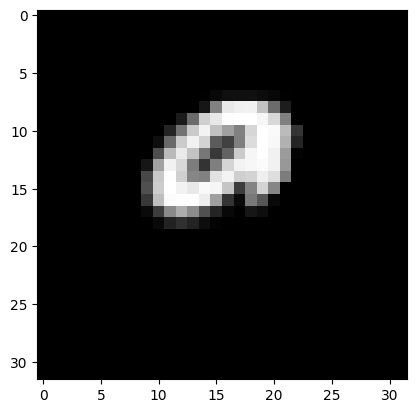

In [ ]:
i = random.randint(0,nr_ex-1)
print(lbls[i])


plt.imshow( mask_int[i,0,:,:] , cmap = 'gray')   


# with torch.no_grad():
#   pred_vals=model(torch.unsqueeze(mask_int[i,:,:,:],0).to(dev))

# _, inds = torch.max(pred_vals,dim=1)
# e = torch.distributions.Categorical(probs =pred_vals).entropy()

# print(pred_vals)
# print(inds)

In [ ]:
# add a dimension to tensor to become B*C*H*W
if len(x_train.shape)==3:
  x_train=x_train.unsqueeze(1)
print(x_train.shape)

# List of indexes on the training set
train_idx = list(range(num_train))

# List of indexes of the test set
test_idx = list(range(num_test))

# Shuffle the training set


random.shuffle(train_idx)
for i in range(10):
  print(train_idx[i])


# Fraction of the original train set that we want to use as validation set
val_frac = 0.1
# Number of samples of the validation set
num_val = int(num_train * val_frac) 
num_train = num_train - num_val

# Split training set
val_idx = train_idx[num_train:]
train_idx = train_idx[:num_train]

print(f"{num_train} samples used as train set")
print(f"{num_val}  samples used as val set")


# Compose transformations
data_transform = transforms.Compose([
  transforms.Resize(32),
  transforms.ToTensor(),
  #transforms.Lambda(torch.bernoulli), #aggiunta da me
])

test_transform = transforms.Compose([
  transforms.Resize(32),
  transforms.ToTensor(),
  #transforms.Lambda(torch.bernoulli),
])
# Load MNIST dataset with transforms
train_set = torchvision.datasets.MNIST(root=root_dir, train=True, download=True, transform=data_transform)
test_set = torchvision.datasets.MNIST(root=root_dir, train=False, download=True, transform=test_transform)

#FATTA DA ME 08 07 22
imgs = torch.zeros(54000,1,32,32)
lbls = torch.zeros(54000)
c=0
for i in train_idx:
  image, label = train_set[i]
  imgs[c,:,:,:]= image
  lbls[c] = label
  c = c+1

ds = torch.cat((imgs, mask_int), 0)

Nan_lbls = torch.ones(nr_ex)*10
ds_lbls = torch.cat((lbls, Nan_lbls), 0)


# image, label = train_set[1]
# plt.imshow(image.squeeze(), cmap='gray')
# print('Label:', label)


# Split train_dataset into training and validation
from torch.utils.data import Subset

val_set = Subset(train_set, val_idx)
train_set = Subset(train_set, train_idx)

# Define loaders
from torch.utils.data import DataLoader
train_loader = DataLoader(train_set, batch_size=64, num_workers=2, shuffle=True, drop_last=True)
val_loader   = DataLoader(val_set,   batch_size=64, num_workers=2, shuffle=False, drop_last=False)
test_loader  = DataLoader(test_set,  batch_size=64, num_workers=2, shuffle=False, drop_last=False)

#fatta da me 08 07. train set con i fake data
_dataset = torch.utils.data.TensorDataset(ds,ds_lbls) # create your datset
train_loader = torch.utils.data.DataLoader(_dataset,batch_size=64, num_workers=2, shuffle=True, drop_last = True) # create your dataloader

torch.Size([60000, 1, 28, 28])
691
44720
19136
34998
51277
24897
42852
50034
38310
41290
54000 samples used as train set
6000  samples used as val set


In [ ]:
class VGGBlock(nn.Module):
    def __init__(self, in_channels, out_channels,batch_norm=False):

        super().__init__()

        conv2_params = {'kernel_size': (3, 3),
                        'stride'     : (1, 1),
                        'padding'   : 1
                        }

        noop = lambda x : x

        self._batch_norm = batch_norm

        self.conv1 = nn.Conv2d(in_channels=in_channels,out_channels=out_channels , **conv2_params)
        self.bn1 = nn.BatchNorm2d(out_channels) if batch_norm else noop
        #self.bn1 = nn.GroupNorm(32, out_channels) if batch_norm else noop

        self.conv2 = nn.Conv2d(in_channels=out_channels,out_channels=out_channels, **conv2_params)
        self.bn2 = nn.BatchNorm2d(out_channels) if batch_norm else noop
        #self.bn2 = nn.GroupNorm(32, out_channels) if batch_norm else noop

        self.max_pooling = nn.MaxPool2d(kernel_size=(2, 2), stride=(2, 2))

    @property
    def batch_norm(self):
        return self._batch_norm

    def forward(self,x):
        x = self.conv1(x)
        x = self.bn1(x)
        x = F.relu(x)

        x = self.conv2(x)
        x = self.bn2(x)
        x = F.relu(x)

        x = self.max_pooling(x)

        return x
'''
#Roba fatta solo per mostrare bene la struttura del modello
class VGG16(nn.Module):

  def __init__(self, input_size, num_classes=10,batch_norm=False):
    super(VGG16, self).__init__()

    self.in_channels,self.in_width,self.in_height = input_size

    self.block_1 = VGGBlock(self.in_channels,64,batch_norm=batch_norm)
    self.block_2 = VGGBlock(64, 128,batch_norm=batch_norm)
    self.block_3 = VGGBlock(128, 256,batch_norm=batch_norm)
    self.block_4 = VGGBlock(256,512,batch_norm=batch_norm)


  @property
  def input_size(self):
      return self.in_channels,self.in_width,self.in_height

  def forward(self, x):

    x = self.block_1(x)
    x = self.block_2(x)
    x = self.block_3(x)
    x = self.block_4(x)

    return x


# Create the model
model = VGG16((1,32,32),batch_norm=True)
print(model)

# Get an element from the dataset
test_x, _ = train_set[0] # each element of the dataset is a couple (image, label)

# Get the size of a sample
test_x.size()

test_x = test_x.unsqueeze(dim=0)
test_x.size()

output=model(test_x)
output.shape

'''


class VGG16(nn.Module):

  def __init__(self, input_size, num_classes=11,batch_norm=False):
    super(VGG16, self).__init__()

    self.in_channels,self.in_width,self.in_height = input_size

    self.block_1 = VGGBlock(self.in_channels,64,batch_norm=batch_norm)
    self.block_2 = VGGBlock(64, 128,batch_norm=batch_norm)
    self.block_3 = VGGBlock(128, 256,batch_norm=batch_norm)
    self.block_4 = VGGBlock(256,512,batch_norm=batch_norm)

    self.classifier = nn.Sequential(
            nn.Linear(2048, 4096),
            nn.ReLU(True),
            nn.Dropout(p=0.65),
            nn.Linear(4096, 4096),
            nn.ReLU(True),
            nn.Dropout(p=0.65),
            nn.Linear(4096, num_classes),
            nn.Softmax(dim=1) 
        )

  @property
  def input_size(self):
      return self.in_channels,self.in_width,self.in_height

  def forward(self, x):

    x = self.block_1(x)
    x = self.block_2(x)
    x = self.block_3(x)
    x = self.block_4(x)
    x = x.view(x.size(0), -1)
    x = self.classifier(x)

    return x

In [ ]:
# Create the model
model = VGG16((1,32,32), batch_norm=True)
dev = torch.device('cuda')
print(dev)

# Define an optimizier
import torch.optim as optim
optimizer = optim.SGD(model.parameters(), lr = 0.01)
# Define a loss 
criterion = nn.CrossEntropyLoss()

cuda


In [ ]:
def train(net, loaders, optimizer, criterion, epochs=20, dev=dev, save_param = False, model_name="VGG16_MNIST"):
    try:
        net = net.to(dev)
        #print(net)
        # Initialize history
        history_loss = {"train": [], "val": [], "test": []}
        history_accuracy = {"train": [], "val": [], "test": []}
        # Store the best val accuracy
        best_val_accuracy = 0

        # Process each epoch
        for epoch in range(epochs):
            # Initialize epoch variables
            sum_loss = {"train": 0, "val": 0, "test": 0}
            sum_accuracy = {"train": 0, "val": 0, "test": 0}
            # Process each split
            for split in ["train", "val", "test"]:
                if split == "train":
                  net.train()
                else:
                  net.eval()
                # Process each batch
                for (input, labels) in loaders[split]:
                    # Move to CUDA
                    input = input.to(dev)
                    labels = labels.to(dev)
                    # Reset gradients
                    optimizer.zero_grad()
                    # Compute output
                    pred = net(input)
                    #pred = pred.squeeze(dim=1) # Output shape is [Batch size, 1], but we want [Batch size]
                    #labels = labels.unsqueeze(1)
                    labels = labels.long()
                    loss = criterion(pred, labels)
                    # Update loss
                    sum_loss[split] += loss.item()
                    # Check parameter update
                    if split == "train":
                        # Compute gradients
                        loss.backward()
                        # Optimize
                        optimizer.step()
                    # Compute accuracy
                    #pred_labels = pred.argmax(1) + 1
                    #pred_labels = (pred >= 0.5).long() # Binarize predictions to 0 and 1
                    _,pred_label = torch.max(pred, dim = 1)
                    pred_labels = (pred_label == labels).float()

                    batch_accuracy = pred_labels.sum().item()/input.size(0)
                    # Update accuracy
                    sum_accuracy[split] += batch_accuracy
            # Compute epoch loss/accuracy
            epoch_loss = {split: sum_loss[split]/len(loaders[split]) for split in ["train", "val", "test"]}
            epoch_accuracy = {split: sum_accuracy[split]/len(loaders[split]) for split in ["train", "val", "test"]}

            # Store params at the best validation accuracy
            if save_param and epoch_accuracy["val"] > best_val_accuracy:
              #torch.save(net.state_dict(), f"{net.__class__.__name__}_best_val.pth")
              from google.colab import drive
              drive.mount('/content/gdrive')

              save_path = "/content/gdrive/My Drive/VGG16_MNIST"

              try:
                  os.mkdir(save_path)
              except:
                  print("Folder already found")
              filename = save_path + '/'+ f"{model_name}_best_val.pth"
     
              torch.save(net.state_dict(), filename)
              best_val_accuracy = epoch_accuracy["val"]

            # Update history
            for split in ["train", "val", "test"]:
                history_loss[split].append(epoch_loss[split])
                history_accuracy[split].append(epoch_accuracy[split])
            # Print info
            print(f"Epoch {epoch+1}:",
                  f"TrL={epoch_loss['train']:.4f},",
                  f"TrA={epoch_accuracy['train']:.4f},",
                  f"VL={epoch_loss['val']:.4f},",
                  f"VA={epoch_accuracy['val']:.4f},",
                  f"TeL={epoch_loss['test']:.4f},",
                  f"TeA={epoch_accuracy['test']:.4f},")
    except KeyboardInterrupt:
        print("Interrupted")
    finally:
        # Plot loss
        plt.title("Loss")
        for split in ["train", "val", "test"]:
            plt.plot(history_loss[split], label=split)
        plt.legend()
        plt.show()
        # Plot accuracy
        plt.title("Accuracy")
        for split in ["train", "val", "test"]:
            plt.plot(history_accuracy[split], label=split)
        plt.legend()
        plt.show()

Mounted at /content/gdrive
Folder already found
Epoch 1: TrL=1.9552, TrA=0.5474, VL=2.3954, VA=0.1112, TeL=2.3954, TeA=0.1136,
Epoch 2: TrL=1.9497, TrA=0.5763, VL=2.3875, VA=0.1112, TeL=2.3873, TeA=0.1136,
Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).
Folder already found
Epoch 3: TrL=1.9004, TrA=0.6343, VL=1.9297, VA=0.6535, TeL=1.9329, TeA=0.6479,
Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).
Folder already found
Epoch 4: TrL=1.6589, TrA=0.8953, VL=1.6670, VA=0.8789, TeL=1.6668, TeA=0.8792,
Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).
Folder already found
Epoch 5: TrL=1.6051, TrA=0.9409, VL=1.6548, VA=0.8897, TeL=1.6543, TeA=0.8897,
Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/

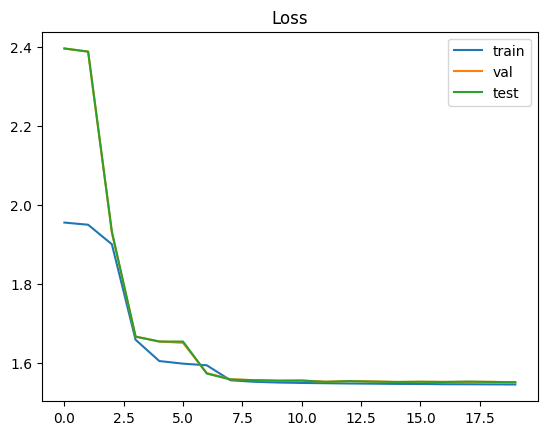

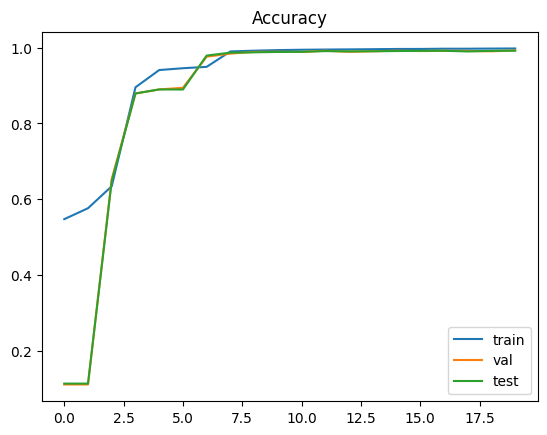

In [ ]:
# Define dictionary of loaders
loaders = {"train": train_loader,
           "val": val_loader,
           "test": test_loader}
           
           
# Train model
train(model, loaders, optimizer, criterion, epochs=20, dev=dev, save_param = True)

In [ ]:
E = torch.zeros(10000)
c=0
for (input, labels) in test_loader:
  input = input.to(dev)
  labels = labels.to(dev)
  with torch.no_grad():
      pred_vals=model(input)
  e = torch.distributions.Categorical(probs =pred_vals).entropy()
  E[c:c+len(labels)] = e
  c+=len(labels)

  
  



In [ ]:
save_path = "/content/gdrive/My Drive/VGG16_MNIST"

filename = save_path + '/entropiesTestSet.pt'
torch.save(E, filename)

     

In [ ]:
g =torch.distributions.Categorical(probs =pred_vals).entropy()

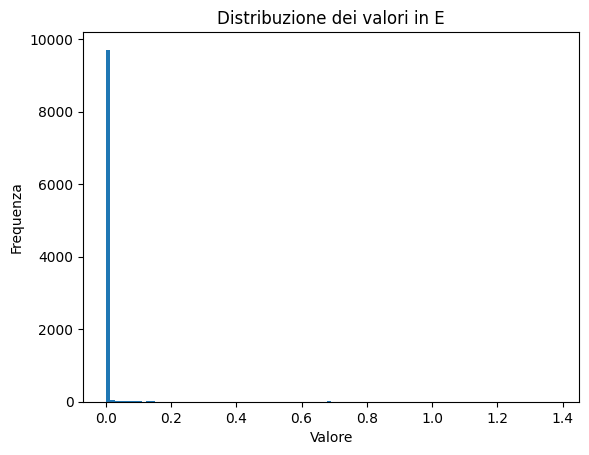

In [ ]:
# Crea un istogramma della distribuzione dei valori
plt.hist(E.numpy(), bins=100)
plt.title('Distribuzione dei valori in E')
plt.xlabel('Valore')
plt.ylabel('Frequenza')
plt.show()

In [ ]:
print(torch.mean(E)+2*torch.std(E))

tensor(0.1301)


tensor([[6.0290e-09, 9.3900e-07, 4.9771e-09, 7.9820e-12, 3.6200e-09, 3.9501e-07,
         1.0800e-09, 2.5935e-08, 1.0628e-13, 4.2422e-11, 1.0000e+00]],
       device='cuda:0') tensor([10], device='cuda:0') tensor([2.0951e-05], device='cuda:0')


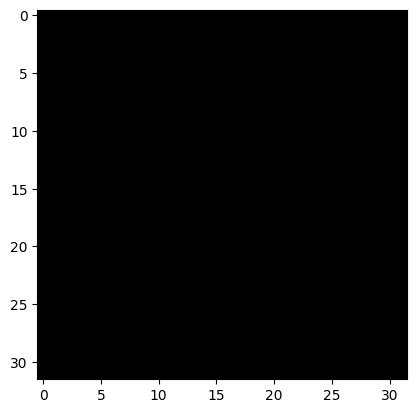

In [ ]:
#test che funzia 08 07 22
image = torch.zeros(1,32,32)


#image, label = train_set[22]

plt.imshow( image[0] , cmap = 'gray')

with torch.no_grad():
  pred_vals=model(torch.unsqueeze(image,0).to(dev))

_, inds = torch.max(pred_vals,dim=1)
e = torch.distributions.Categorical(probs =pred_vals).entropy()
print(pred_vals,inds,e)